In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('monthly-milk-production-pounds-p.csv')
data.columns = ['Month', 'Milk in Pounds per Cow']
data.drop(168, axis=0,inplace=True)
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)
data.tail()

,Milk in Pounds per Cow
Month,
1975-08-01,858.0
1975-09-01,817.0
1975-10-01,827.0
1975-11-01,797.0
1975-12-01,843.0


In [3]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Milk in Pounds per Cow,168.0,754.708333,102.204524,553.0,677.75,761.0,824.5,969.0


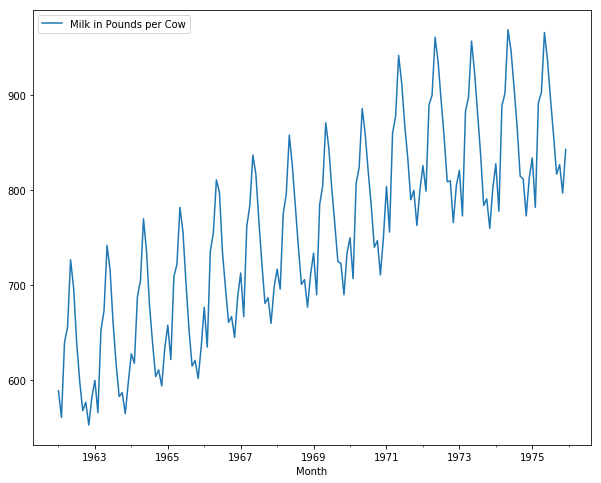

In [4]:
data.plot(figsize=(10,8))

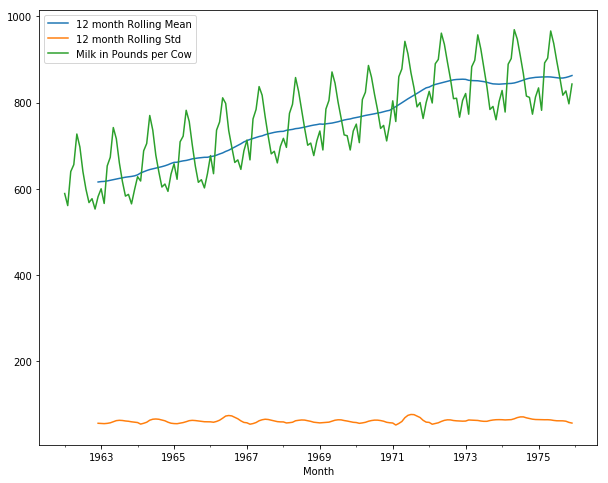

In [5]:
time_series = data['Milk in Pounds per Cow']
time_series.rolling(12).mean().plot(label='12 month Rolling Mean')
time_series.rolling(12).std().plot(label='12 month Rolling Std')
time_series.plot(figsize=(10,8))
plt.legend();

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

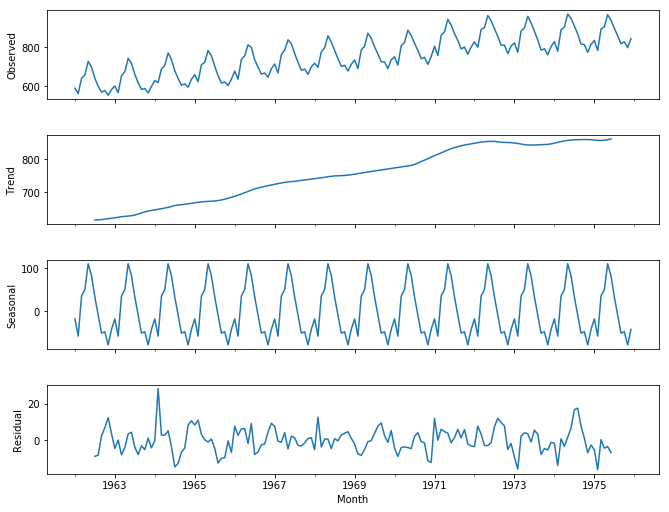

In [7]:
decomp = seasonal_decompose(time_series, freq=12)
fig = decomp.plot()
fig.set_size_inches(10,8)

In [8]:
from statsmodels.tsa.stattools import adfuller 
result = adfuller(data['Milk in Pounds per Cow'])

In [9]:
def adf_check(time_series):
    result = adfuller(time_series)
    print("Augmented Dicky-Fuller Test")
    labels = ['ADF Test Statistics', 'p-value', '# of flags', 'Number of Observations used']
    
    for value, label in zip(result, labels):
        print(label+" : "+str(value))
    if result[1] <= 0.5:
        print("Strong evidence against null hypothesis")
        print("reject null hypothesis")
        print("Data has no unit root and is stationary")
    else: 
        print("Weak evidence against null hypothesis")
        print("Fail to reject null hypothesis")
        print("Data has a unit root and is non-stationary")

In [10]:
adf_check(data['Milk in Pounds per Cow'])

Augmented Dicky-Fuller Test
ADF Test Statistics : -1.3038115874221294
p-value : 0.6274267086030316
# of flags : 13
Number of Observations used : 154
Weak evidence against null hypothesis
Fail to reject null hypothesis
Data has a unit root and is non-stationary


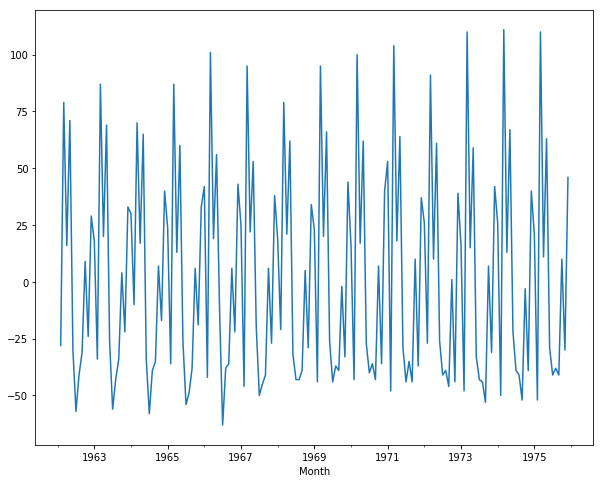

In [11]:
data['First Difference'] = data['Milk in Pounds per Cow'] - data['Milk in Pounds per Cow'].shift(1)
data['First Difference'].plot(figsize=(10,8));

In [12]:
adf_check(data['First Difference'].dropna())

Augmented Dicky-Fuller Test
ADF Test Statistics : -3.0549955586530704
p-value : 0.030068004001785647
# of flags : 14
Number of Observations used : 152
Strong evidence against null hypothesis
reject null hypothesis
Data has no unit root and is stationary


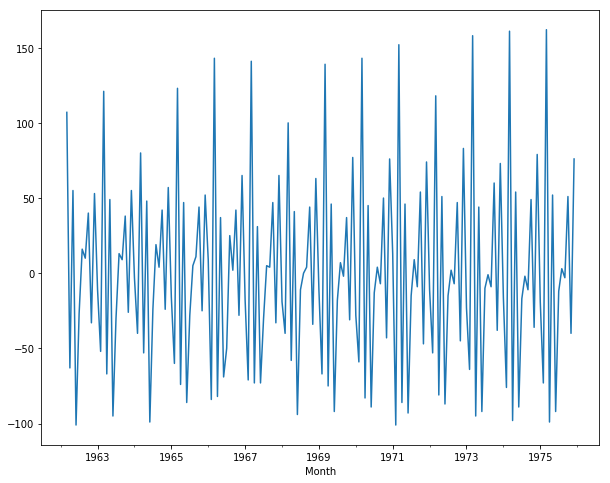

In [13]:
data['Second Difference'] = data['First Difference'] - data['First Difference'].shift(1)
data['Second Difference'].plot(figsize=(10,8));

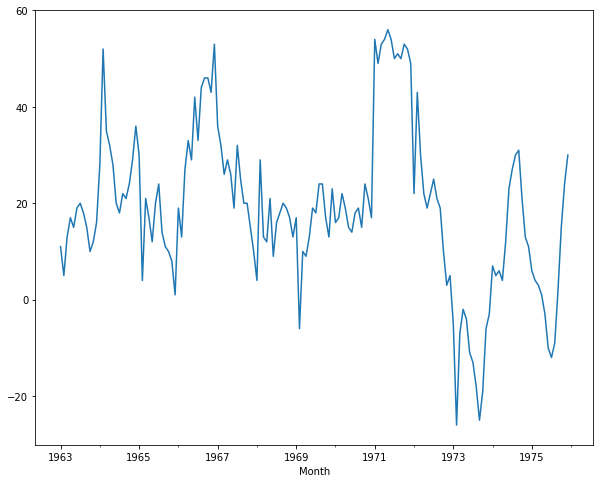

In [14]:
data['Seasonal Difference'] = data['Milk in Pounds per Cow'] - data['Milk in Pounds per Cow'].shift(12)
data['Seasonal Difference'].plot(figsize=(10,8));

In [15]:
adf_check(data['Seasonal Difference'].dropna())

Augmented Dicky-Fuller Test
ADF Test Statistics : -2.335419314359398
p-value : 0.1607988052771135
# of flags : 12
Number of Observations used : 143
Strong evidence against null hypothesis
reject null hypothesis
Data has no unit root and is stationary


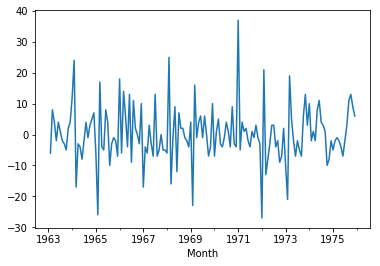

In [16]:
data['Seasonal First Difference'] = data['First Difference'] - data['First Difference'].shift(12)
data['Seasonal First Difference'].plot();

In [17]:
adf_check(data['Seasonal First Difference'].dropna())

Augmented Dicky-Fuller Test
ADF Test Statistics : -5.038002274921984
p-value : 1.8654234318788342e-05
# of flags : 11
Number of Observations used : 143
Strong evidence against null hypothesis
reject null hypothesis
Data has no unit root and is stationary


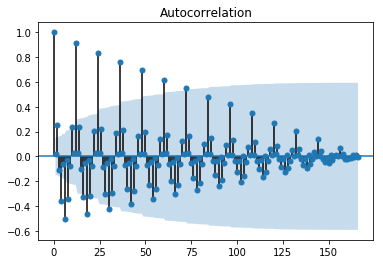

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig_first = plot_acf(data['First Difference'].dropna());

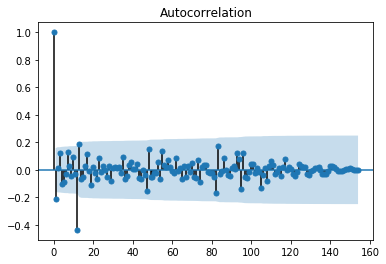

In [19]:
fig_seasonal_first = plot_acf(data['Seasonal First Difference'].dropna())

/Users/bogdanivanyuk/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


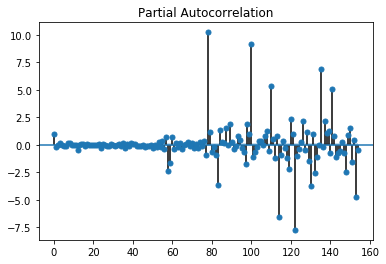

In [20]:
result = plot_pacf(data['Seasonal First Difference'].dropna())

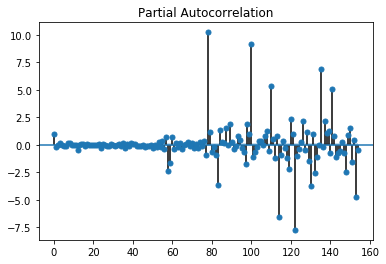

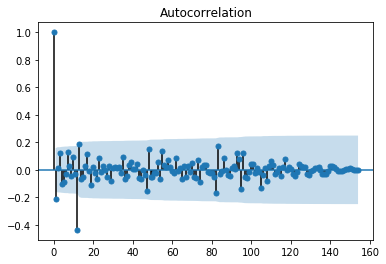

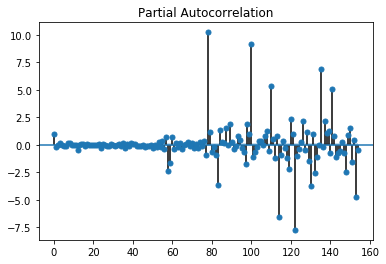

In [21]:
plot_acf(data['Seasonal First Difference'].dropna())
plot_pacf(data['Seasonal First Difference'].dropna())

# ARIMA Model

In [23]:
from statsmodels.tsa.arima_model import ARIMA

In [26]:
model = sm.tsa.statespace.SARIMAX(data['Milk in Pounds per Cow'], order=(0,1,0), seasonal_order=(1,1,1,12))
results = model.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:             Milk in Pounds per Cow   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -534.065
Date:                            Sat, 09 Mar 2019   AIC                           1074.131
Time:                                    20:08:10   BIC                           1083.261
Sample:                                01-01-1962   HQIC                          1077.839
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0449      0.106     -0.422      0.673      -0.253       0.163
ma.S.L12      -0.5860      0.102   

/Users/bogdanivanyuk/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


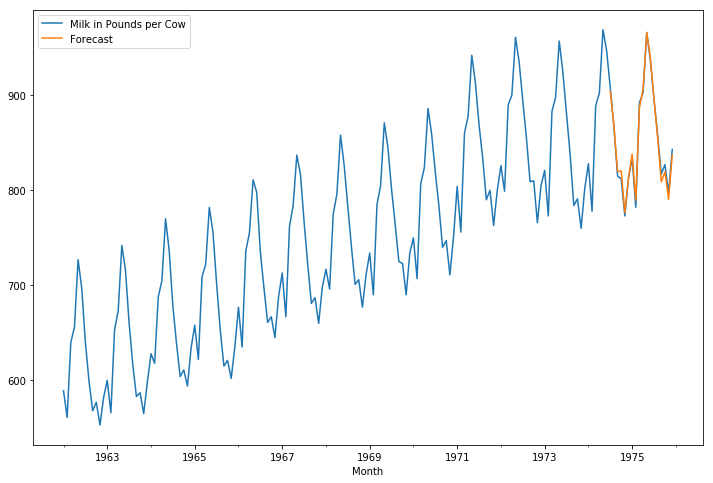

In [29]:
data['Forecast'] = results.predict(start=150, end=168)
data[['Milk in Pounds per Cow', 'Forecast']].plot(figsize=(12,8));

In [32]:
from pandas.tseries.offsets import DateOffset
future_dates = [data.index[-1]+DateOffset(months=x) for x in range(1,24)]

In [33]:
future_dates

[Timestamp('1976-01-01 00:00:00'),
 Timestamp('1976-02-01 00:00:00'),
 Timestamp('1976-03-01 00:00:00'),
 Timestamp('1976-04-01 00:00:00'),
 Timestamp('1976-05-01 00:00:00'),
 Timestamp('1976-06-01 00:00:00'),
 Timestamp('1976-07-01 00:00:00'),
 Timestamp('1976-08-01 00:00:00'),
 Timestamp('1976-09-01 00:00:00'),
 Timestamp('1976-10-01 00:00:00'),
 Timestamp('1976-11-01 00:00:00'),
 Timestamp('1976-12-01 00:00:00'),
 Timestamp('1977-01-01 00:00:00'),
 Timestamp('1977-02-01 00:00:00'),
 Timestamp('1977-03-01 00:00:00'),
 Timestamp('1977-04-01 00:00:00'),
 Timestamp('1977-05-01 00:00:00'),
 Timestamp('1977-06-01 00:00:00'),
 Timestamp('1977-07-01 00:00:00'),
 Timestamp('1977-08-01 00:00:00'),
 Timestamp('1977-09-01 00:00:00'),
 Timestamp('1977-10-01 00:00:00'),
 Timestamp('1977-11-01 00:00:00')]

In [35]:
future_data = pd.DataFrame(index=future_dates, columns=data.columns)
final_data = pd.concat([data, future_data])

In [38]:
final_data['Forecast'] = results.predict(start=168, end=192)

In [39]:
final_data.tail()

,Milk in Pounds per Cow,First Difference,Second Difference,Seasonal Difference,Seasonal First Difference,Forecast
1977-07-01,NaN,NaN,NaN,NaN,NaN,951.525867
1977-08-01,NaN,NaN,NaN,NaN,NaN,911.918957
1977-09-01,NaN,NaN,NaN,NaN,NaN,865.881182
1977-10-01,NaN,NaN,NaN,NaN,NaN,871.027295
1977-11-01,NaN,NaN,NaN,NaN,NaN,836.962996


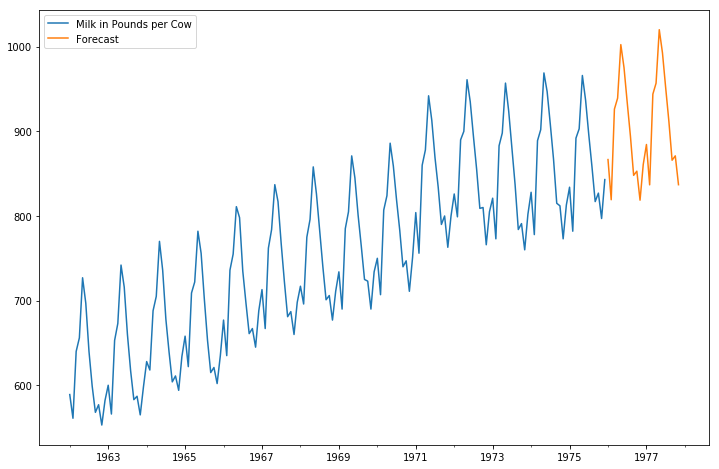

In [40]:
final_data[['Milk in Pounds per Cow', 'Forecast']].plot(figsize=(12,8))